In [41]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys
import h5py
from torch.optim import lr_scheduler


sys.path.append("../../")
from metric import *
from util import *
from model.pinn import PINNs, MLP


In [42]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [43]:
# get data
# 几何区域：-1<=x<=1, 0<=t<=0.6
# 均匀网格离散化：101*101
# res: 所有散点坐标
X_SIZE = 101
T_SIZE = 101

res, b_init, b_end, b_left, b_right = get_data([-1, 1], [2, 0], X_SIZE, T_SIZE) 
res_test, _, _, _, _ = get_data([-1, 1], [2, 0], X_SIZE, T_SIZE) 

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_init = torch.tensor(b_init, dtype=torch.float32, requires_grad=True).to(device)  # init
b_end = torch.tensor(b_end, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)  # right
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)  # left

# 分别提取散点的x t坐标 --> 列表
x_res, t_res = res[:,0:1], res[:,1:2]
x_init, t_init = b_end[:,0:1], b_end[:,1:2]
x_end, t_end = b_end[:,0:1], b_end[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]

# 有限体积采样边界点
DFVM_solver = DFVMsolver(1, device)
X_inL, X_inR = DFVM_solver.get_vol_data2(res)
X_inL  = X_inL.requires_grad_(True).to(device)  # 内部点的CV边界采样点
X_inR  = X_inR.requires_grad_(True).to(device)

print('x_inL: ', X_inL.shape)

print('res shape: ', res.shape, 'b_left shape: ', b_left.shape, 'b_right shape: ', b_right.shape, 'b_upper shape: ', b_init.shape, 'b_lower shape: ', b_end.shape)

x_inL:  torch.Size([10201, 2])
res shape:  torch.Size([10201, 2]) b_left shape:  torch.Size([101, 2]) b_right shape:  torch.Size([101, 2]) b_upper shape:  torch.Size([101, 2]) b_lower shape:  torch.Size([101, 2])


In [44]:
# Train PINNs -- MLP
model = PINNs(in_dim=2, hidden_dim=128, out_dim=1, num_layer=8).to(device)
# 更换激活函数

model.apply(init_weights)
# optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = lr_scheduler.ExponentialLR(optim, gamma=0.9, verbose=True)

print(model)
print(get_n_params(model))  # 总的参数量

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=1, bias=True)
  )
)
99585


/tmp/ipykernel_844593/2796238932.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


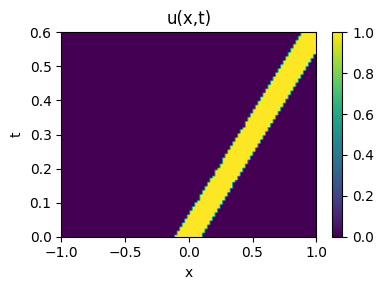

In [45]:
# 调整区域大小

a = x_res <= t_res/2 + 0.1
b = x_res >= t_res/2 - 0.1 
c = a & b
c = c.reshape(101, 101)

data = torch.where(c, 1, 0).cpu().numpy() 
plt.figure(figsize=(4,3))
plt.imshow(data, extent=[-1,1,0,0.6], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()


In [46]:
# trian
loss_track = []
step_size = 5000

def jacobian(y, x, i, j):
    '''
    input: y[], x[]
    '''
    y = y[:,i]
    grad = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0][:,j]  # y 相对于 x 的第 j 维的偏导数
    return grad.reshape(-1, 1)

def pde_burgers1D(x, model, nu):
    '''
    u_t + uu_x = 0

    input: x:[x, xL, xR] [内部点、CV左边界点、CV右边界点]
    '''
    x, t, xL, xR = x
    y = model(x, t)
    dy_x = jacobian(y, x, i=0, j=0)
    dy_t = jacobian(y, t, i=0, j=0)
    yL = model(xL[:, 0:1], t)
    yR = model(xR[:, 0:1], t)
    dyR_x = jacobian(yR, xR, i=0, j=0)
    dyL_x = jacobian(yL, xL, i=0, j=0)
    res = (dy_t + y * dy_x)*0.0002 - nu*(dyR_x - dyL_x)
    return res.reshape(-1, 1)

# for i in tqdm(range(300000)):
#     optim.zero_grad()
    
#     pred_res = model(x_res, t_res)  # (n, 1)
#     pred_init = model(x_init, t_init)  # init
#     pred_left = model(x_left, t_left)  # right
#     pred_right = model(x_right, t_right)  # left
    
#     u = pred_res
#     u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
#     u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    
#     # GA_PINNs：计算权重，乘以每个残差点的res
#     alpha = 1
#     beta = 1.25
#     Lambda = ( 1 / (1 +  alpha * torch.abs(u_x)**beta ) ) # Works fine 每个残差点，梯度越大，lambda越小；

#     loss_res_1 = torch.mean(Lambda * ((u_t + u * u_x) ** 2))  
#     loss_res_2 = torch.mean( (1-Lambda) * (pde_burgers1D((x_res, t_res, X_inL, X_inR), model, 0.001)**2) )
#     loss_res =  loss_res_1 + loss_res_2  # lambda大的地方梯度小，使用强形式；lamba小的地方梯度大，使用弱形式；
#     loss_ic = torch.mean(torch.where(x_init <= 0, (pred_init-1) ** 2, pred_init ** 2))
#     loss_bcL = torch.mean((pred_left - 1) ** 2)
#     loss_bcR = torch.mean((pred_right) ** 2)
#     loss_bc = loss_bcL + loss_bcR

#     loss = loss_res + loss_ic + loss_bc
    
#     loss.backward()
#     optim.step()

#     if (i+1) % step_size == 0:
#         scheduler.step()

#     with torch.no_grad():
#         loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])
    
#     if i % 5000 == 0:
#         print('Iter %d, res1: %.5e, res2: %.5e, Lossic: %.5e, Lossbc: %.5e' % (i, loss_res_1.item(), loss_res_2.item(), loss_ic.item(), loss_bc.item()))
def pinn_burgers1D(x_res, t_res, model):
    u = model(x_res, t_res)   # (n, 1)
    u_x = torch.autograd.grad(u, x_res, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(u, t_res, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

    return (u_t + u * u_x) ** 2

for i in tqdm(range(1000)):
    optim.zero_grad()
    
    pred_init = model(x_init, t_init)  # init
    pred_left = model(x_left, t_left)  # right
    pred_right = model(x_right, t_right)  # left
    
    # 残差点loss分区域计算：在[-0.1, 0.1]使用强形式，其他使用弱形式
    a = x_res <= t_res/2 + 0.1
    b = x_res >= t_res/2 - 0.1 
    c = a & b
    loss_res = torch.mean(torch.where(c, pde_burgers1D((x_res, t_res, X_inL, X_inR), model, 0.001)**2, 
                                      pinn_burgers1D(x_res, t_res, model)))
    loss_ic = torch.mean(torch.where(x_init <= 0, (pred_init-1) ** 2, pred_init ** 2))  # 初值：u(x, 0) = 1, x<=0; u(x, 0) = 0, x>0
    loss_bc = torch.mean((pred_left - 1) ** 2 + (pred_right) ** 2)

    loss = loss_res + 100*loss_ic + loss_bc
    
    loss.backward()
    optim.step()

    if (i+1) % step_size == 0:
        scheduler.step()

    with torch.no_grad():
        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])
    
    if i % 5000 == 0:
        print('Iter %d, res: %.5e, Lossic: %.5e, Lossbc: %.5e' % (i, loss_res.item(), loss_ic.item(), loss_bc.item()))

  0%|          | 4/1000 [00:00<00:32, 30.58it/s]

Iter 0, res: 1.25730e-04, Lossic: 5.14551e-01, Lossbc: 9.76901e-01


100%|██████████| 1000/1000 [00:32<00:00, 31.10it/s]


In [47]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000116, Loss_BC: 0.000014, Loss_IC: 0.000007
Train Loss: 0.000137


(101, 101)
relative L1 error: 0.348382
relative L2 error: 0.585340
MSE:  0.19675404
RMSE:  0.20006089
L2RE:  15.243877
MaxE:  0.4822274


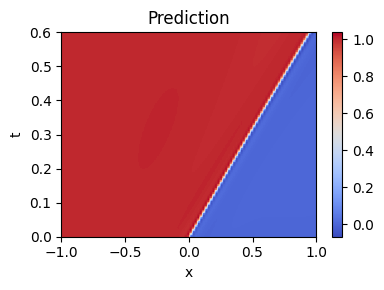

In [48]:
# Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

mat = scipy.io.loadmat('./burgers_move.mat')
u = mat['u'].reshape(X_SIZE, T_SIZE)

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()
pred = pred.reshape(X_SIZE, T_SIZE)

print(pred.shape)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))
print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

L2re = L2RE(torch.tensor(u), torch.tensor(pred)).mean()
MaxE = MaxError(torch.tensor(u), torch.tensor(pred)).mean()
Mse = MSE(torch.tensor(u), torch.tensor(pred)).mean()
Rmse = RMSE(torch.tensor(u), torch.tensor(pred)).mean()
print("MSE: ", Mse.detach().cpu().numpy())
print("RMSE: ", Rmse.detach().cpu().numpy())
print("L2RE: ", L2re.detach().cpu().numpy())
print("MaxE: ", MaxE.detach().cpu().numpy())


plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[-1,1,0,0.6], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Prediction')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/newlayer_30000/mix_0.1_pred.png')
plt.show()

# 5000次，误差不如10000次
# relative L1 error: 0.015820
# relative L2 error: 0.107065
# MSE:  0.0065826895
# RMSE:  0.009084644
# L2RE:  0.8758644
# MaxE:  0.12773629
# 10000次表现很好
# relative L1 error: 0.005569
# relative L2 error: 0.052316
# MSE:  0.0015717186
# RMSE:  0.0031980232
# L2RE:  0.43031794
# MaxE:  0.10504309
# 30000次
# relative L1 error: 0.010913
# relative L2 error: 0.077946
# MSE:  0.0034889057
# RMSE:  0.006266776
# L2RE:  0.46589938
# MaxE:  0.11506442
# 100000次
# relative L1 error: 0.019373
# relative L2 error: 0.110716
# MSE:  0.0070392266
# RMSE:  0.011125361
# L2RE:  nan
# MaxE:  0.1461392

# newlayer 30000次
# relative L1 error: 0.025178
# relative L2 error: 0.155191
# MSE:  0.013830503
# RMSE:  0.014458783
# L2RE:  406.61838
# MaxE:  0.13291337
# newlayer 100000次
# relative L1 error: 0.011651
# relative L2 error: 0.096417
# MSE:  0.00533841
# RMSE:  0.0066908677
# L2RE:  6.3360667
# MaxE:  0.12847108


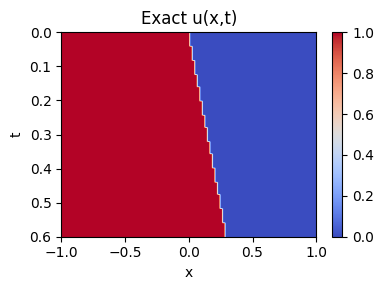

In [49]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[-1, 1, 0.6, 0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/exact.png')
plt.show()

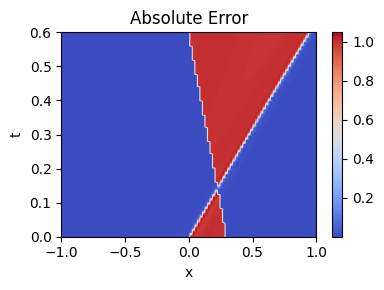

In [50]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[-1, 1, 0, 0.6], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/newlayer_30000/mix_0.1_error.png')
plt.show()

(101, 101)


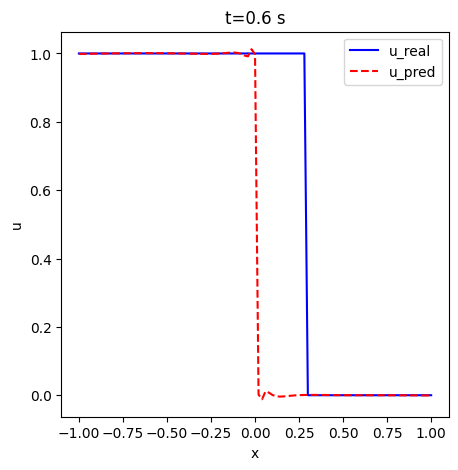

In [52]:
# 绘制t时刻的折线图
print(u.shape)
import matplotlib.pyplot as plt
import numpy as np

# 假设的时间序列数据
x = np.linspace(-1, 1, 101)
u_real = u[-1, :]  # 实际值，例如使用正弦波
u_pred = pred[-1, :]  # 预测值，添加一些噪声

plt.figure(figsize=(5, 5))
plt.plot(x, u_real, label='u_real', color='blue')  # 实际值曲线
plt.plot(x, u_pred, label='u_pred', color='red', linestyle='--')  # 预测值曲线

plt.title('t=0.6 s')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(False)
plt.savefig('./image/newlayer_30000/mix_0.1_0.6.png')
plt.show()
